In [1]:
import numpy as np
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
debug = True

In [4]:
# headers = ['burst','class','3 class','complete','duration','sig_dur','sig_asym','sig_lag','pulse pk flux','sig_pk flux','S(1+2+3)','sigS(1+2+3)','hr31 (erg)','sig hr31 (erg)','log10(dur)','asymmetry','lag','log10(p256)','log10(S)','log10(hr31)']

data = []
import csv
with open('../data/project_two/2010 GRB pulse table.csv', newline='\n') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(reader)
    for row in reader:
        data.append(np.asarray(row))
data = np.asarray(data)

In [5]:
training_data = data[:700,:]
test_data = data[701:,:]

X1 = training_data[:,14].astype(np.float32) # log10(dur)
X2 = training_data[:,15].astype(np.float32) # asymmetry
Y = training_data[:,18].astype(np.float32) # log10(lag)
X = training_data[:,14:16].astype(np.float32) # log10(duration) and asymmetry

Y_test = test_data[:,18].astype(np.float32)
X_test = test_data[:,14:16].astype(np.float32) # log10(duration) and asymmetry

In [6]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X1,Y)
Yhat = intercept + slope*X1
print( "Yhat = {0:0.2f} + {1:0.2f}X1".format( intercept, slope ) )
print( "r value = {0:0.2f}".format( r_value ) )
Xp = np.linspace( np.min(X1), np.max( X1 ) )
Yline = intercept + slope*Xp

Yhat = -6.68 + 0.53X1
r value = 0.61


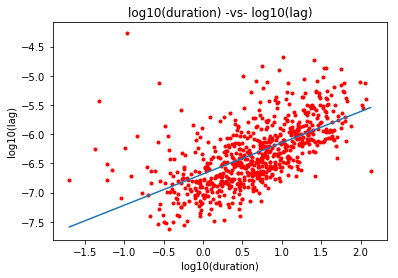

In [7]:
plt.figure()
plt.plot( Xp, Yline )
plt.title( "log10(duration) -vs- log10(lag)")
plt.scatter( X1, Y, color='red', marker='.' )
plt.xlabel( "log10(duration)" )
plt.ylabel( "log10(lag)" )
plt.show()

In [8]:
model = linear_model.LinearRegression()
model.fit(X,Y)
Yhat = model.predict(X_test)
print(model.coef_[0])
print(model.coef_[1])
print('r coefficients: \n\tX1 '+str(model.coef_[0])+'\n\tX2 '+str(model.coef_[0]))

0.5248198
0.05837578
r coefficients: 
	X1 0.5248198
	X2 0.5248198


In [9]:
MSE = mean_squared_error(Y_test, Yhat)
RMSD = np.sqrt(mean_squared_error(Y_test, Yhat))
MAE = mean_absolute_error(Y_test, Yhat)
print('MSE: {0:0.3f}'.format(MSE))
print('RMSD: {0:0.3f}'.format(RMSD))
print('MAE: {0:0.3f}'.format(MAE))

MSE: 0.200
RMSD: 0.447
MAE: 0.337


In [10]:
S_idx = data[:,1] == 'S'
not_S_idx = data[:,1] != 'S'

D1 = data[S_idx,:]
D2 = data[not_S_idx,:]

D1x = D1[:,14].astype(np.float32)
D2x = D2[:,14].astype(np.float32)
D1y = D1[:,18].astype(np.float32)
D2y = D2[:,18].astype(np.float32)

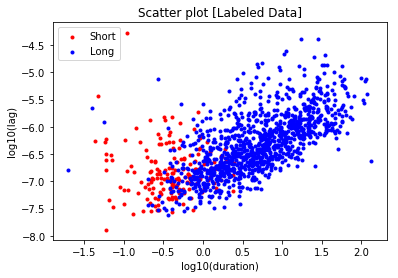

In [11]:
plt.figure()
plt.title( "Scatter plot [Labeled Data]")
plt.xlabel( "log10(duration)" )
plt.ylabel( "log10(lag)" )
plt.scatter( D1x, D1y, color='red', marker='.', label="Short")
plt.scatter( D2x, D2y, color='blue', marker='.', label="Long")
plt.legend()
plt.show()

In [12]:
clf = svm.SVC(kernel='linear')
clf.fit(np.dstack((data[:,14],data[:,18]))[0], S_idx)
print( 'Intercept: '+str(clf.intercept_[0]) )
print( 'Correlation coefficients: '+str(clf.coef_[0]) )

Intercept: 0.10809000518711105
Correlation coefficients: [-3.14875548  0.15482133]


In [13]:
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-0.5, 0)
yy = a * xx - (clf.intercept_[0]) / w[1]
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

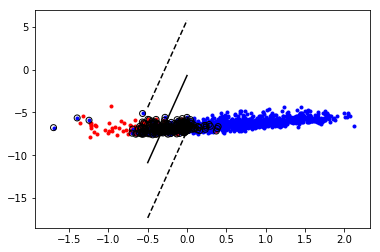

In [14]:
plt.figure()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')
plt.scatter( D1x, D1y, color='red', marker='.', label="Short")
plt.scatter( D2x, D2y, color='blue', marker='.', label="Long")
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], marker='o',
                facecolors='none', edgecolors='black')
plt.show()

In [15]:
y_true = S_idx
y_predicted = clf.predict(np.dstack((data[:,14],data[:,18]))[0])
tn, fp, fn, tp = confusion_matrix(y_true,y_predicted).ravel()
PPV = tp/(tp+fp)
NPV = tn/(tn+fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)

print('PPV: {0:0.03f}'.format(PPV))
print('NPV: {0:0.03f}'.format(NPV))
print('TPR: {0:0.03f}'.format(TPR))
print('TNR: {0:0.03f}'.format(TNR))

PPV: 0.762
NPV: 0.941
TPR: 0.626
TNR: 0.968
